# $ Q( \sigma ) $ and friends

## Introduction

In this homework, I'm evaluating several on-policy and off-policy variants of TD algorithms. Main question I'm aiming to answer is whether it preferable to have action-value backups with sampled or with branched transitions (see image below taken from *Sutton & Barto, 2016*).
<img src="images/backups.png" width=500>

## Some helper code

In [10]:
%matplotlib inline

In [95]:
import copy
import gym
import itertools
import matplotlib
import numpy as np
import os
import pandas as pd
import sys

from collections import defaultdict, namedtuple
from functools import partial
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from tqdm import tqdm

from lib.algos.sarsa import sarsa
from lib.algos.utils import ConstantLearningRate, epsilon_greedy_policy
from lib.envs.gridworld import GridworldEnv
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib.envs.cliff_walking import CliffWalkingEnv
from lib.plotting import EpisodeStats

plt.style.use('ggplot')

## Implementation of the $ Q (\sigma) $ algorithm

I've spent quite a bit of time trying to fix the bugs in this implementation. Two of those bugs crept their way to my notebook directly from the pseudo-code from the book (page 164):
* *"All store and access operations can take their index mod $ n $"*. As algorithm in this particular form uses values from $ n + 1 $ steps (including the current one) it's safer to use "mod $ n + 1 $" operations. 
* I believe the correct upate rule for $ \rho $ is $ \rho \leftarrow \rho (1 - \sigma_{k + 1} + \sigma_{k + 1} \rho_{k + 1}) $

In [12]:
from IPython.display import clear_output

def debug_callback(episode_idx, stats):
    clear_output(wait=True)
    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.plot(stats.episode_rewards[: episode_idx + 1])
    plt.show()

In [26]:
def q_sigma(env, num_episodes, num_steps=1, behavior_policy=None, target_policy=None, epsilon=0.1,
            sample_sigma=lambda state, action: 0.0, discount_factor=0.95, alpha=ConstantLearningRate(0.5),
            debug_callback=None):
    """
    Q(sigma) algorithm from the book "Reinforcement Learning: An Introduction" (Sutton & Barto, 2016).
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run.
        num_steps: Number of steps in a backup.
        behavior_policy: Behavior policy. If None, uses epsilon-greedy.
        target_policy: Target policy to estimate Q-function for. If None, learns optimal epsilon-greedy.
        epsilon: Epsilon in an epsilon-greedy policy. Unused if target and behavior policies are set by the user. 
        sample_sigma: Function to compute sigma for a given state-action pair.
        discount_factor: The discount factor for the rewards.
        alpha: TD learning rate rule.
        
    Returns:
        A tuple (Q, stats).
        Q: The action-value estimate according to the algorithm (a dictionary mapping state -> action values). 
        stats: Useful statistics of the training procedure.
    """
    
    # We start with an all-zero Q-function estimate.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keep track of useful statistics.
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # Define policies.
    behavior_policy = (behavior_policy if behavior_policy is not None else
                       partial(epsilon_greedy_policy, Q=Q, epsilon=epsilon, num_actions=env.action_space.n))
    target_policy = (target_policy if target_policy is not None else
                     partial(epsilon_greedy_policy, Q=Q, epsilon=epsilon, num_actions=env.action_space.n))
    
    def sample_action(state):
        action_probs = behavior_policy(state)
        action = np.random.choice(env.action_space.n, p=action_probs)
        return action, action_probs
    
    # Create storage.
    class Storage(object):
        def __init__(self, num_steps):
            self.num_steps = num_steps
            self.storage = defaultdict(lambda: np.zeros(num_steps + 1))

        def __getitem__(self, key):
            return self.storage[key[0]][key[1] % (self.num_steps + 1)]

        def __setitem__(self, key, value):
            self.storage[key[0]][key[1] % (self.num_steps + 1)] = value
        
    storage = Storage(num_steps)
    
    # Run episodes.
    for episode_idx in xrange(num_episodes):
        episode_length = np.inf

        state = env.reset()
        storage['state', 0] = state
        action, _ = sample_action(state)
        storage['action', 0] = action
        storage['Q', 0] = Q[state][action]
  
        done = False
        for t in itertools.count():
            if t < episode_length:
                # Act according to the behavior policy.
                state, reward, done, _ = env.step(action)
                storage['state', t + 1] = state
                last_state = state
                
                # Update reward statistics.
                stats.episode_rewards[episode_idx] += reward
                
                if done:
                    episode_length = t + 1
                    storage['delta', t] = reward - storage['Q', t]
                    stats.episode_lengths[episode_idx] = t + 1
                else:
                    action, action_probs = sample_action(state)
                    storage['action', t + 1] = action
                    sigma = sample_sigma(state, action)
                    storage['sigma', t + 1] = sigma
                    storage['Q', t + 1] = Q[state][action]
                    
                    action_target_probs = target_policy(state)
                    storage['delta', t] = (reward + discount_factor * sigma * storage['Q', t + 1] +
                                           discount_factor * (1.0 - sigma) * action_target_probs.dot(Q[state]) -
                                           storage['Q', t])
                    storage['action_target_prob', t + 1] = action_target_probs[action]
                    storage['rho', t + 1] = action_target_probs[action] / action_probs[action]

            # Update the Q-function estimates for the past state-action pairs.  
            tau = t - num_steps + 1
            if tau >= 0:
                rho = 1
                E = 1
                G = storage['Q', tau]

                for k in xrange(tau, min(t + 1, episode_length)):
                    G = G + E * storage['delta', k]
                    sigma = storage['sigma', k + 1]
                    E = discount_factor * E * ((1.0 - sigma) * storage['action_target_prob', k + 1] + sigma)
                    rho = rho * (1 - sigma + sigma * storage['rho', k + 1])

                # Finally, update the estimate.
                state_tau, action_tau = int(storage['state', tau]), int(storage['action', tau])
                Q[state_tau][action_tau] += alpha(state_tau, action_tau) * rho * (G - Q[state_tau][action_tau])
                
            if tau >= episode_length - 1:
                if debug_callback is not None:
                    debug_callback(episode_idx, stats)
                break
               
    return Q, stats

### Sanity check

$ Q ( \sigma ) $ with $ \sigma = 1 $ and one-step backup is just the good old Sarsa.

In [20]:
env = CliffWalkingEnv()

np.random.seed(0)
sarsa_Q, stats = sarsa(env, 1, discount_factor=1.0, alpha=ConstantLearningRate(0.5))

np.random.seed(0)
qsigma_Q, stats = q_sigma(env, 1, num_steps=1, discount_factor=1.0, sample_sigma=lambda state, action: 1.0,
                          alpha=ConstantLearningRate(0.5))

for k in sarsa_Q.keys():
    assert np.allclose(sarsa_Q[k], qsigma_Q[k])
    
for k in qsigma_Q.keys():
    assert np.allclose(sarsa_Q[k], qsigma_Q[k])
    
print "Sanity check passed!"

Sanity check passed!


## Cliff walking experiments

In [22]:
env = CliffWalkingEnv()

### Sarsa vs Expected Sarsa

To start off, I reproduce some of the results from *van Seijen et al., 2009* (Figure 2) and *Sutton & Barto, 2016*.

In [120]:
num_trials = 20
num_episodes = 100
alphas = np.linspace(0.1, 1.0, 10)

def job(seed, alpha, use_expected):
    np.random.seed(seed=seed)
    _, stats = sarsa(env, num_episodes, use_expected=use_expected, discount_factor=1.0,
                     alpha=ConstantLearningRate(alpha))
    return stats

avg_rewards = defaultdict(lambda: np.full(len(alphas), np.nan))
for i, alpha in enumerate(alphas):
    for use_expected in [False, True]:
        all_stats = Parallel(n_jobs=8)(
            [delayed(job)(s, alpha, use_expected) for s in np.random.randint(0, num_trials * 1000, num_trials)])
        avg_rewards[use_expected][i] = np.mean([np.mean(s.episode_rewards) for s in all_stats])

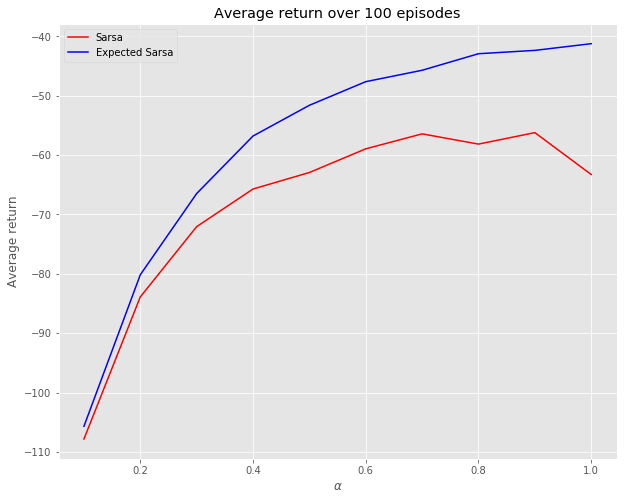

In [123]:
fig = plt.figure(figsize=(10, 8))
    
plt.plot(alphas, avg_rewards[False], 'r', label='Sarsa')
plt.plot(alphas, avg_rewards[True], 'b', label='Expected Sarsa')

plt.xlabel('$ \\alpha $')
plt.ylabel("Average return")
plt.title("Average return over 100 episodes")
plt.legend()

plt.show(fig)

As we can see, **Expected Sarsa** outperforms **Sarsa** for all learning rate values. This is due to reduced variance of the updates. Note, how ES achieves the best interim average reward when $ \alpha  = 1 $. Sarsa, on the other hand, requires smaller $ \alpha $ to cope with the higher variance.

### Comparison of $ n $-step backup variants

Now, I run a set of experiments for three variations of $ Q( \sigma ) $:
* $ \sigma = 0 $. Sampling at every step = **Sarsa**.
* $ \sigma = 1 $. Expectation at every step = **Tree Backup** (*Precup et al., 2000*).
* $ \sigma $ is a Bernoulli RV with $ p = 0.5 $. Something in between the two above.

In [126]:
num_trials = 40
num_episodes = 100

configs = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'epsilon': [0.1, 0.3],
    'num_steps': [5, 10, 15],
    'algo': ['sarsa', 'tree', 'rnd']
}

def job(seed, algo, num_steps, alpha, epsilon):
    np.random.seed(seed=seed)
    if algo == 'sarsa':
        sample_sigma=lambda state, action: 1.0
    elif algo == 'tree':
        sample_sigma=lambda state, action: 0.0
    else:
        sample_sigma=lambda state, action: np.single(np.random.binomial(1, 0.5))
    _, stats = q_sigma(env, num_episodes, num_steps=num_steps, epsilon=epsilon,
                       sample_sigma=sample_sigma, discount_factor=1.0,
                       alpha=ConstantLearningRate(alpha))
    return stats

for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}_{num_steps}_{alpha}_{epsilon}'.format(**config)
    filename = 'results/{}.npy'.format(name)
    if os.path.exists(filename):
        continue
    all_stats = Parallel(n_jobs=8)(
        [delayed(job)(s, **config) for s in np.random.randint(0, num_trials * 1000, num_trials)])
    np.save(filename, np.array([np.mean(s.episode_rewards) for s in all_stats]))

In [127]:
avg_rewards = []
keys = []
names = configs.keys()
for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}_{num_steps}_{alpha}_{epsilon}'.format(**config)
    filename = 'results/{}.npy'.format(name)
    avg_rewards.append(np.mean(np.load(filename)))
    keys.append(tuple(config[k] for k in names))
    
s = pd.Series(avg_rewards, index=pd.MultiIndex.from_tuples(keys, names=names))
s = s.reorder_levels(['epsilon', 'num_steps', 'algo', 'alpha']).sort_index()

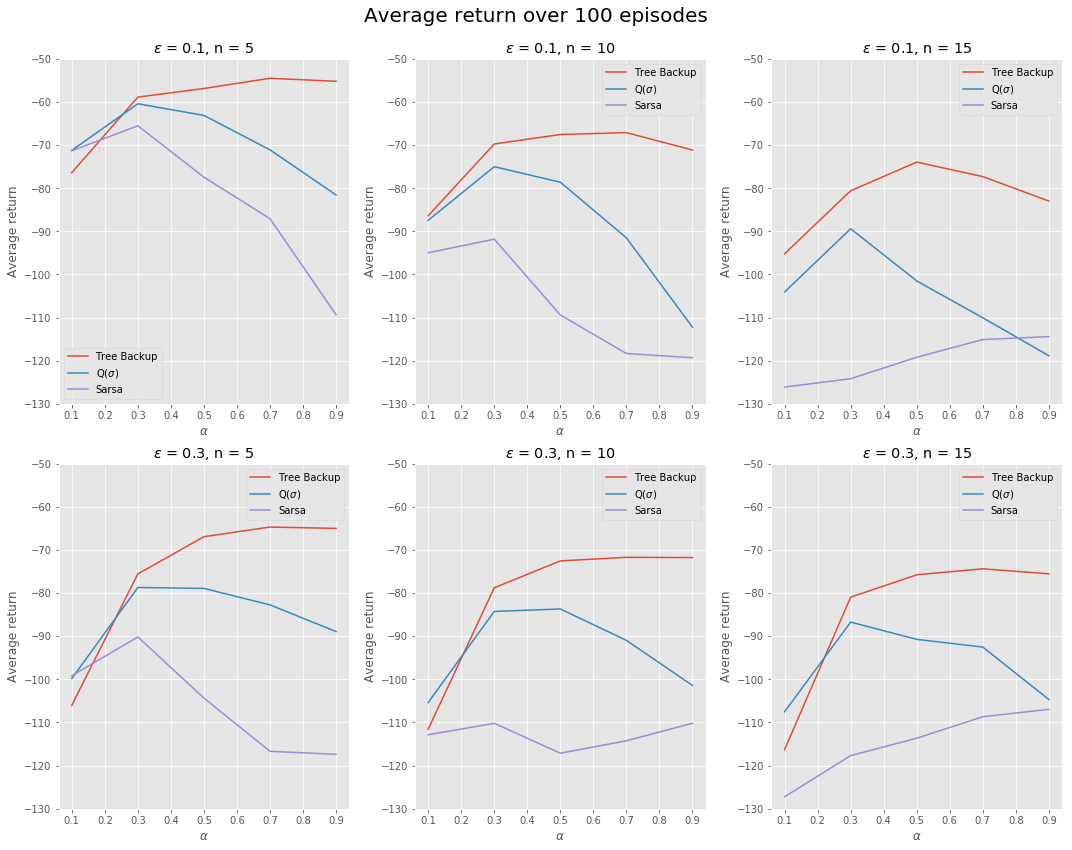

In [128]:
fig = plt.figure(figsize=(15, 12))

algo_map = {
    'sarsa': 'Sarsa',
    'tree': 'Tree Backup',
    'rnd': 'Q($ \sigma $)'
}
algos_order = ['tree', 'rnd', 'sarsa']   
    
for i, (idx, s_select) in enumerate(s.groupby(level=['epsilon', 'num_steps'])):
    plt.subplot(2, 3, i + 1)
    for algo in algos_order:
        a = s_select[idx][algo]
        plt.plot(list(a.index), a.values, label=algo_map[algo])
    plt.ylim(-130, -50)
    plt.xlabel('$ \\alpha $')
    plt.ylabel('Average return')
    plt.title('$ \epsilon $ = {epsilon}, n = {num_steps}'.format(epsilon=idx[0], num_steps=idx[1]))
    plt.legend(loc='best')

plt.suptitle('Average return over {} episodes'.format(num_episodes), fontsize=20)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show(fig)

Just like in the previous experiment, taking expectation at every step turns out to be a better overall strategy. Moreover, the more sampling is involved the worse is the performance — the third variation of $ Q( \sigma ) $ is, indeed, in between two extremes in terms of achieved average return.

### Interpolating between Sarsa and Tree Backup

In order to emphasize that the expectation backup dominates sampling, I take the third variation of $ Q ( \sigma ) $ and gradually change $ p $ from 0 to 1. My hypothesis is that every next step is a strict improvement over the previous one.

In [129]:
num_trials = 40
num_episodes = 100
epsilon = 0.1
alpha = 0.5
num_steps = 5

configs = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
    'prob': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
}

def job(seed, alpha, prob):
    np.random.seed(seed=seed)
    sample_sigma=lambda state, action: np.single(np.random.binomial(1, prob))
    _, stats = q_sigma(env, num_episodes, num_steps=num_steps, epsilon=epsilon,
                       sample_sigma=sample_sigma, discount_factor=1.0,
                       alpha=ConstantLearningRate(alpha))
    return stats

for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = 'rnd2_{alpha}_{prob}'.format(**config)
    filename = 'results/{}.npy'.format(name)
    if os.path.exists(filename):
        continue
    all_stats = Parallel(n_jobs=8)(
        [delayed(job)(s, **config) for s in np.random.randint(0, num_trials * 1000, num_trials)])
    np.save(filename, np.array([np.mean(s.episode_rewards) for s in all_stats]))

In [130]:
avg_rewards = []
keys = []
names = configs.keys()
for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = 'rnd2_{alpha}_{prob}'.format(**config)
    filename = 'results/{}.npy'.format(name)
    avg_rewards.append(np.mean(np.load(filename)))
    keys.append(tuple(config[k] for k in names))
    
s = pd.Series(avg_rewards, index=pd.MultiIndex.from_tuples(keys, names=names))
s = s.reorder_levels(['prob', 'alpha']).sort_index()

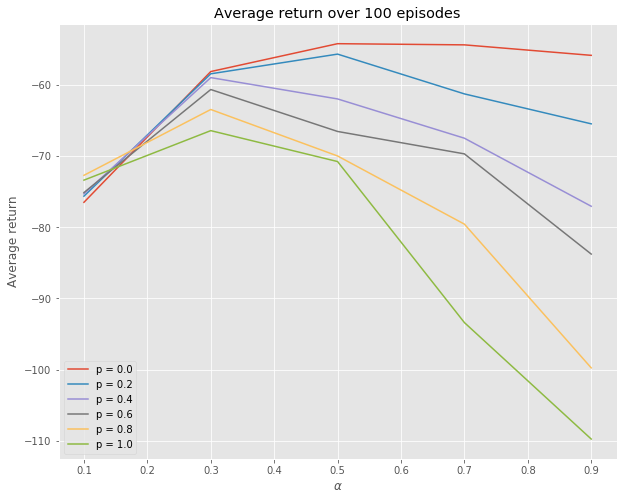

In [131]:
fig = plt.figure(figsize=(10, 8))
    
for prob in configs['prob']:
    a = s[float(prob)]
    plt.plot(list(a.index), a.values, label='p = {prob}'.format(prob=prob))

plt.xlabel('$ \\alpha $')
plt.ylabel("Average return")
plt.title("Average return over {} episodes".format(num_episodes))
plt.legend(loc='lower left')

plt.show(fig)

As we can see, the hypothesis is more or less true (modulo the hiccup for $ \alpha = 0.1 $).

## On Importance Sampling and Tree Backup

It turns out that in case of TD(0), it has been shown that not only **Expected Sarsa** is superior to **Sarsa** but but also **Tree Backup** dominates **Per-decision Importance Sampling** (*van Hasselt, 2011*) for off-policy learning. I tried to play around with the proof to extend it for TD(n) but the math becomes a bit messy although I believe it should be possible to derive the same result for multi-step methods.